# Biodiversity indexes

Paper work in progress. https://www.authorea.com/users/23640/articles/151071

In [1]:
%pylab inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate
from scipy.spatial import distance

import os
os.chdir("/home/essicolo/Documents/professionnel/ulaval/projets/2017_biodiversite/")
from scripts import codapy

Populating the interactive namespace from numpy and matplotlib


Biodiversity is widely understood as a way to measure the health of an ecosystem. It is often expressed by relating counts of individuals as relative amounts of species or genetic traits found in a given region, then assessed by synthesizing proportions into a single index to compare ecosystems across time or space. The most common indexes are the Shannon-Weaver index and the Simpson index, which can be slightly modified and inversed.

**Shannon diversity**

$H' = -\sum_{i=1}^R p_i \ln p_i$

In [2]:
def shannon(p):
    H = 0
    for i in range(0, len(p)):
        H = H - p[i]  * np.log(p[i])
    return(H)

**Simpson diversity**

$ D_1 = 1 - \sum_{i=1}^R p_i^2$

In [3]:
def simpson(p):
    D = 0
    for i in range(0, len(p)):
        D = D + p[i]**2
    return(1-D)

**Inverse Simpson diversity**

$D_2 = \frac {1} {\Sigma_{i=1}^s p_i^2}$

In [4]:
def inv_simpson(p):
    D = 0
    for i in range(0, len(p)):
        D = D + p[i]**2
    return(1/D)

The Berger-Parker diversity index has also been used, as well as the Gini-Simpson diversiity.

**Berger-Parker**

$max(p)$

In [5]:
def berger(p):
    return(np.max(p))

**Gini-Simpson**

$1 - \lambda = 1 - \sum_{i=1}^R p_i^2 = 1 - 1/{}^2D$

The Aitchison distance, named after John Aitchison - founder of compositional data analysis - (Aitchison 1986), is used to compute distances between compositions, i.e. vectors of proportions or relative amounts. The maximum diversity is obtained at the barycenter of a compositional vector, i.e. $\left[1/D_1, 1/D_2, ..., 1/D_D \right]$, where $D$ is the number of components. The Aitchison distance barycenter of a composition, where all proportions are equal, and a vector of proportions can thus be used as diversity index.

**Aitchison diversity**

$Ad\ =\ \sqrt{\frac{1}{2D}\Sigma_{i=1}^D\Sigma_{j=1}^D\left(\log\left(\frac{x_i}{x_j}\right)-\log\left(\frac{y_i}{y_j}\right)\right)}$

The Aitchison distance can also be computed as a Euclidean distance between the coordinates of a composition. Expressing compositions as coordinates can be made by a rational sceme of balances between them, which extracts the information as log ratios. Balances can be organized from phylogenetic trees. Each balance between species can be multiplied by a weight (non-linear operation in the simplex) expressing the importance of the balance across a phylogenetic tree: with smaller weights for closely related species and larger weights for less related species. The weigthed Aitchison distance could thus be used as a phylogenetic biodiversity index.

In [6]:
def aitchison(u, v = None):
    if v is None:
        v = np.repeat(1/u.shape[0], u.shape[0])
    log_u_v = np.log(u / v)
    dist = norm(log_u_v - np.mean(log_u_v))
    return(dist)

# $\alpha$-diversity

Here I create a grid of 2 components ranging from 1e-10 to 1 - 1e-10, than I compute diversity indexes on this vector.

In [7]:
comp_vec = np.vstack((np.linspace(1e-10, 1-1e-10, 1001), np.linspace(1 - 1e-10, 1e-10, 1001))).T
sh_vec = np.apply_along_axis(shannon, 1, comp_vec)
si_vec = np.apply_along_axis(simpson, 1, comp_vec)
isi_vec = np.apply_along_axis(inv_simpson, 1, comp_vec)
bp_vec = np.apply_along_axis(berger, 1, comp_vec)
ad_vec = np.apply_along_axis(aitchison, 1, comp_vec)

All indexes are plotted against the fist component.

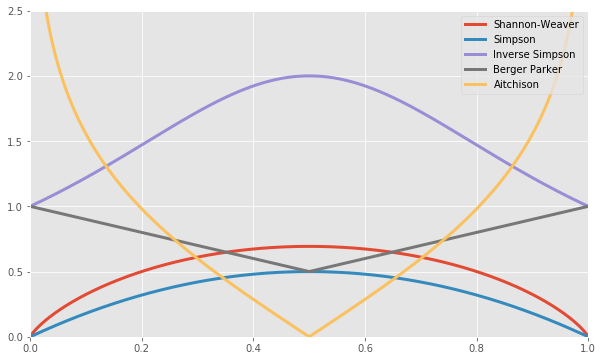

In [8]:
plt.figure(figsize = (10, 6))
plt.style.use('ggplot')
plt.xlim([0, 1])
plt.ylim([0, 2.5])
plt.plot(comp_vec[:,0], sh_vec, label = "Shannon-Weaver", linewidth = 3)
plt.plot(comp_vec[:,0], si_vec, label = "Simpson", linewidth = 3)
plt.plot(comp_vec[:,0], isi_vec, label = "Inverse Simpson", linewidth = 3)
plt.plot(comp_vec[:,0], bp_vec, label = "Berger Parker", linewidth = 3)
plt.plot(comp_vec[:,0], ad_vec, label = "Aitchison", linewidth = 3)
plt.legend(loc = 1)

Shannon-Weaver and Simpson indexes are convex, while the inverse Simpson is bell-shaped. The Berger-Parker and Aithison indexed are not continuous. While the Berger-Parker index is linear in this metric, the Aitchison index grow to infinite with asymptotes at 0 ant 1.

The patterns of the indexes can be mapped in a ternary diagram. This function transforms 3D compositions in a ternary representation.

In [9]:
def tern2cart(coord):
    x, y, z = coord[0], coord[1], coord[2]
    tot = x + y + z
    x, y, z = x/tot, y/tot, z/tot
    x_1 = (2*y + z)/(2*(x+y+z))
    x_2 = np.sqrt(3)*z/(2*(x+y+z)) 
    return([x_1, x_2])

`plot_tern` is a function to plot just the ternary structure. Other layers can be plotted after.

In [10]:
def plot_tern(grid_by = 0.1, tick_length = 0.01, labels = ['A', 'B', 'C'], show_arrows = True, show_grid = True, show_ticks = True, show_tick_labels = True):
    plt.figure(figsize = (12 , 12 * np.sqrt(3)/2))
    plt.xlim([-0.25, 1])
    plt.ylim([-0.25 * np.sqrt(3)/2, np.sqrt(3)/2])
    plt.axis('off')
    plt.plot([0, 0.5, 1, 0], [0, np.sqrt(3)/2, 0, 0], color = "black")

    if grid_by is not None:
        ngrid = int(1 + 1 / grid_by)
        xseq = np.linspace(0.0, 1.0, ngrid)
        yseq = xseq * np.sqrt(3)/2
        xlseq = xseq/2
        xrseq = 0.5 + xlseq

        for i in range(0, ngrid):
            if show_grid:
                # grid
                plt.plot([xlseq[i], xseq[i]], [yseq[i], 0], color = "#E3E3E3")
                plt.plot([xrseq[i], xseq[i]], [yseq[::-1][i], 0], color = "#E3E3E3")
                plt.plot([xlseq[i], xrseq[::-1][i]], [yseq[i], yseq[i]], color = "#E3E3E3")

            if show_ticks:
                plt.plot([xlseq[i], xlseq[i] - tick_length], [yseq[i], yseq[i]], color = "#505050") # left ticks
                plt.plot([xrseq[i], xrseq[i] + tick_length * np.sqrt(3)/2], [yseq[::-1][i], yseq[::-1][i] + tick_length / (np.sqrt(3)/2) ], color = "#505050") # right ticks
                plt.plot([xseq[i], xseq[i] + tick_length * np.sqrt(3)/2], [0, 0 - tick_length / (np.sqrt(3)/2) ], color = "#505050")

            if show_tick_labels:
                plt.text(xlseq[i] - 0.035, yseq[i], 
                         s = str(xseq[i]),#[(rounding % xseq[i])],
                         horizontalalignment='center',
                         verticalalignment='center',
                         fontsize = 12, color = '#505050') # left labels
                plt.text(x = xrseq[::-1][i] + 0.025, 
                         y = yseq[i] + 0.035, 
                         s = str(xseq[::-1][i]), #[(rounding % xseq[::-1][i])],
                         rotation = 60,
                         horizontalalignment='center',
                         verticalalignment='center',
                         fontsize = 12, color = '#505050') # right labels
                plt.text(x = xseq[i] + 0.015, 
                         y = 0 - 0.035, 
                         s = str(xseq[::-1][i]), # [(rounding % xseq[::-1][i])], 
                         rotation = -60, 
                         horizontalalignment='center',
                         verticalalignment='center',
                         fontsize = 12, color = '#505050') # bottom labels

    if labels is not None:
        xseq = [0.5, 0.87, 0.12]
        yseq = [-0.13, np.sqrt(3)/4, np.sqrt(3)/4]
        rotseq = [0, -60, 60]
        for i in range(0, len(labels)):
            plt.text(xseq[i], yseq[i], s = labels[i], rotation = rotseq[i], 
                     horizontalalignment='center',
                     verticalalignment='center',
                    fontsize = 18)

    if show_arrows:
        arrrow_paw_len = 0.03
        arrow_offset = 0.1
        bottom_x_start, bottom_x_end = [0.7, 0.3]
        bottom_y_start, bottom_y_end = [0 - arrow_offset, 0 - arrow_offset]
        left_x_start, left_x_end = [0.15 - arrow_offset, 0.35 - arrow_offset]
        left_y_start, left_y_end = [np.sqrt(3) * (left_x_start + arrow_offset), np.sqrt(3) * (left_x_end + arrow_offset)]
        right_x_start, right_x_end = [0.65 + arrow_offset, 0.85 + arrow_offset]
        right_y_start, right_y_end = [left_y_end, left_y_start]
        plt.plot([bottom_x_start, bottom_x_start - arrrow_paw_len * np.cos(np.pi/3)], 
                 [bottom_y_start, bottom_y_start + arrrow_paw_len * np.sin(np.pi/3)], color = "black") # bottom paw
        plt.arrow(x = bottom_x_start, y = bottom_y_start, 
                  dx = bottom_x_end - bottom_x_start, dy = bottom_y_end - bottom_y_start,
                 head_width=0.02, color = 'black')
        plt.plot([left_x_start, left_x_start + arrrow_paw_len], 
                 [left_y_start, left_y_start], color = "black") # left paw
        plt.arrow(x = left_x_start, y = left_y_start, 
                  dx = left_x_end - left_x_start, dy = left_y_end - left_y_start,
                 head_width=0.02, color = 'black')
        plt.plot([right_x_start, right_x_start - arrrow_paw_len * np.cos(np.pi/3)],
                 [right_y_start, right_y_start - arrrow_paw_len * np.sin(np.pi/3)], color = "black")
        plt.arrow(x = right_x_start, y = right_y_start, 
                  dx = right_x_end - right_x_start, dy = right_y_end - right_y_start,
                 head_width=0.02, color = 'black')

To create a compositional grid, I create a grid in the ilr space, then backtransform it as compositions.

In [11]:
ngrid = 100
sbp = np.array([[1, 1,-1],
                [1,-1, 0]])
ilr_grid = np.array(np.meshgrid(np.linspace(-6, 5, num = ngrid), np.linspace(-6, 5, num = ngrid))).reshape(2, ngrid**2).T
ilr_grid = (ilr_grid, sbp)
comp_grid = codapy.InvLogRatio(ilr_grid).ilr(sbp)
coord_grid = np.apply_along_axis(func1d = tern2cart, axis = 1, arr = comp_grid)

Compute the $\alpha$-diversity indexes on this grid.

In [12]:
sh_grid = np.apply_along_axis(func1d = shannon, axis = 1, arr = comp_grid)
si_grid = np.apply_along_axis(func1d = simpson, axis = 1, arr = comp_grid)
isi_grid = np.apply_along_axis(func1d = inv_simpson, axis = 1, arr = comp_grid)
bp_grid = np.apply_along_axis(func1d = berger, axis = 1, arr = comp_grid)
ad_grid = np.apply_along_axis(func1d = aitchison, axis = 1, arr = comp_grid)

Interpolate diversity indexes to a mesh.

In [13]:
nmesh = 100
coordx_i = np.linspace(coord_grid[:, 0].min(), coord_grid[:, 0].max(), nmesh)
coordy_i = np.linspace(coord_grid[:, 1].min(), coord_grid[:, 1].max(), nmesh)
sh_mesh = scipy.interpolate.griddata((coord_grid[:, 0], coord_grid[:, 1]), sh_grid,
                                 (coordx_i[None,:], coordy_i[:,None]), method='cubic')
si_mesh = scipy.interpolate.griddata((coord_grid[:, 0], coord_grid[:, 1]), si_grid,
                                 (coordx_i[None,:], coordy_i[:,None]), method='cubic')
isi_mesh = scipy.interpolate.griddata((coord_grid[:, 0], coord_grid[:, 1]), isi_grid,
                                 (coordx_i[None,:], coordy_i[:,None]), method='cubic')
bp_mesh = scipy.interpolate.griddata((coord_grid[:, 0], coord_grid[:, 1]), bp_grid,
                                 (coordx_i[None,:], coordy_i[:,None]), method='cubic')
ad_mesh = scipy.interpolate.griddata((coord_grid[:, 0], coord_grid[:, 1]), ad_grid,
                                 (coordx_i[None,:], coordy_i[:,None]), method='cubic')

The proportion of categorized individuals (by species of higher clade) is relative to what is considered to be the total number of categories. The definition of a category, as well as the categories which a re considered in a study belongs to the methodology. In any case, categorical diversities, like biodiversity, must deal with proportions, which are amounts relative to a constant sum κ\kappaκ​ for which the information lies within the ratio among the categories.

$\kappa = \Sigma_{i=1}^S p_i$

Let ourselves take three species: A, B and C. Because they sum to a constant, if proportion of species A increase, at least one of B and C must decrease. In fact, a vector of proportions holds a degree of freedom less than its length. Accordingly, three proportions of species carry two information and can be plotted in 2D. The ternary diagram of proportions of species A, B and C can be plotted.

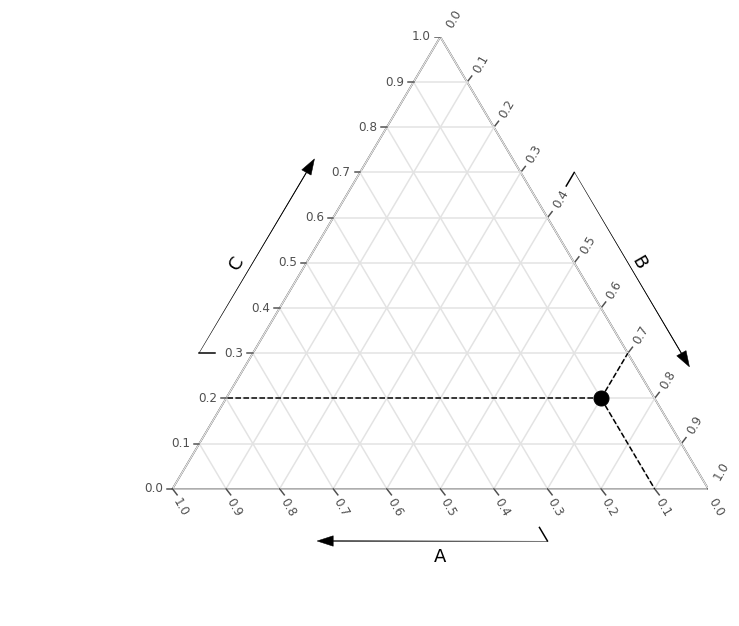

In [14]:
point = tern2cart([0.1, 0.7, 0.2])
bot = tern2cart([0.1, 0.9, 0])
left = tern2cart([0.8, 0, 0.2])
right = tern2cart([0, 0.7, 0.3])
plot_tern(show_grid = True)
plt.plot(point[0], point[1], marker = '.', ms = 30, color = 'black')
plt.plot([point[0], bot[0]], [point[1], bot[1]], '--', color = 'black')
plt.plot([point[0], left[0]], [point[1], left[1]], '--', color = 'black')
plt.plot([point[0], right[0]], [point[1], right[1]], '--', color = 'black')

#### Shannon entropy

<a list of 8 text.Text objects>

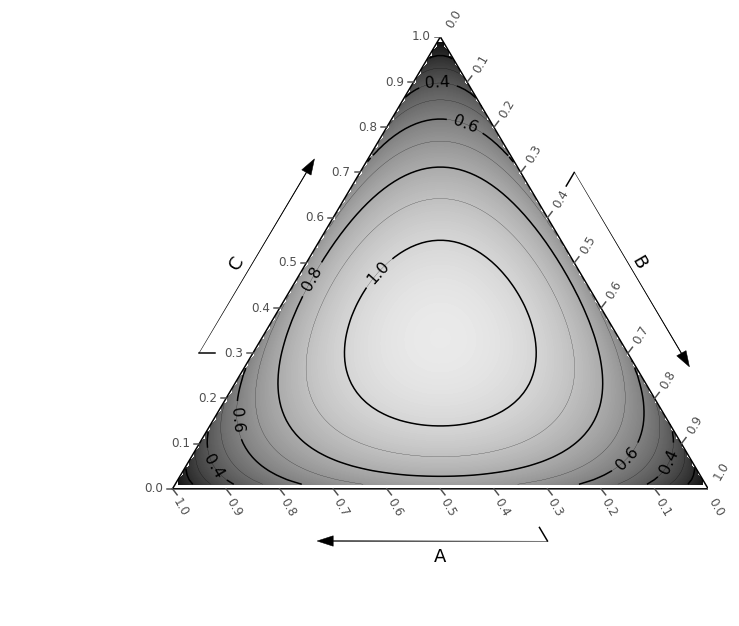

In [15]:
plot_tern(show_grid = False)
plt.contourf(coordx_i, coordy_i, sh_mesh, levels = np.linspace(0, 1.2, 200), cmap = 'gray')
plt.contour(coordx_i, coordy_i, sh_mesh, levels = np.linspace(0, 1.2, 13), colors = 'black', linewidths = 0.2)
CS = plt.contour(coordx_i, coordy_i, sh_mesh, levels = np.linspace(0, 1.2, 7), colors = 'black')
plt.clabel(CS, inline=1, fontsize=16, fmt='%1.1f', colors = 'black')

#### Simpson diversity

<a list of 13 text.Text objects>

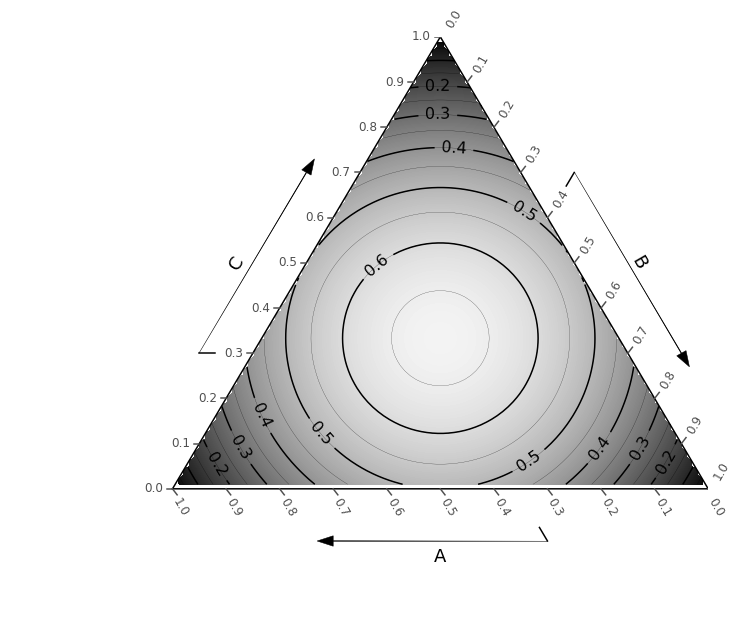

In [16]:
plot_tern(show_grid = False)
plt.contourf(coordx_i, coordy_i, si_mesh, levels = np.linspace(0, 0.7, 200), cmap = 'gray') # BuPu
plt.contour(coordx_i, coordy_i, si_mesh, levels = np.linspace(0, 0.7, 15), colors = 'black', linewidths = 0.2)
CS = plt.contour(coordx_i, coordy_i, si_mesh, levels = np.linspace(0, 0.7, 8), colors = 'black')
plt.clabel(CS, inline=1, fontsize=16, fmt='%1.1f', colors = 'black')

#### Inverse simpson diversity

<a list of 7 text.Text objects>

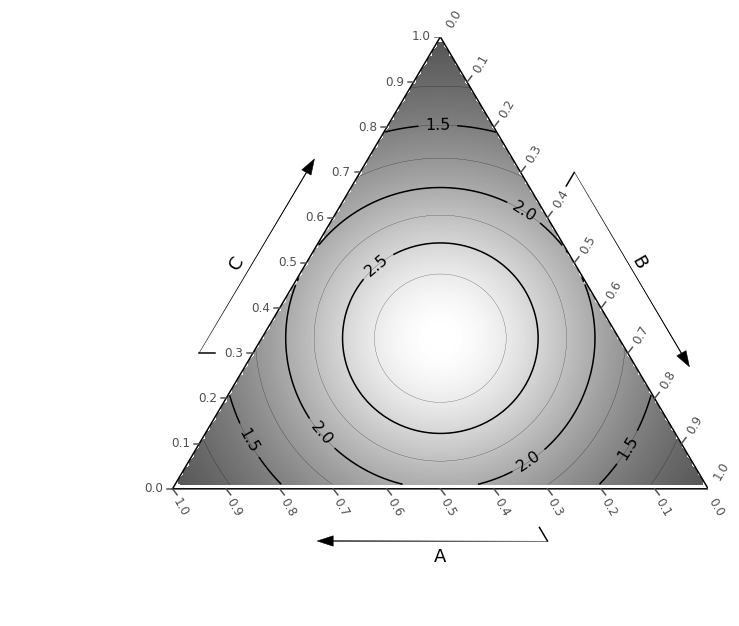

In [17]:
plot_tern(show_grid = False)
plt.contourf(coordx_i, coordy_i, isi_mesh, levels = np.linspace(0, 3, 200), cmap = 'gray')
plt.contour(coordx_i, coordy_i, isi_mesh, levels = np.linspace(0, 3, 13), colors = 'black', linewidths = 0.2)
CS = plt.contour(coordx_i, coordy_i, isi_mesh, levels = np.linspace(0, 3, 7), colors = 'black')
plt.clabel(CS, inline=1, fontsize=16, fmt='%1.1f', colors = 'black')

#### Berger-Parker

<a list of 16 text.Text objects>

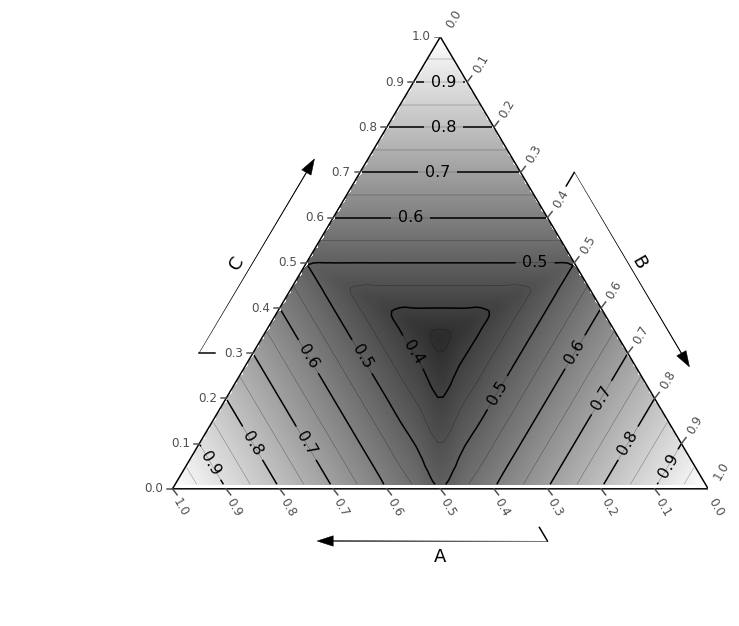

In [18]:
plot_tern(show_grid = False)
plt.contourf(coordx_i, coordy_i, bp_mesh, levels = np.linspace(0.2, 1, 200), cmap = 'gray')
plt.contour(coordx_i, coordy_i, bp_mesh, levels = np.linspace(0, 1, 21), colors = 'black', linewidths = 0.2)
CS = plt.contour(coordx_i, coordy_i, bp_mesh, levels = np.linspace(0, 1, 11), colors = 'black')
plt.clabel(CS, inline=1, fontsize=16, fmt='%1.1f', colors = 'black')

#### Aitchison diversity

<a list of 7 text.Text objects>

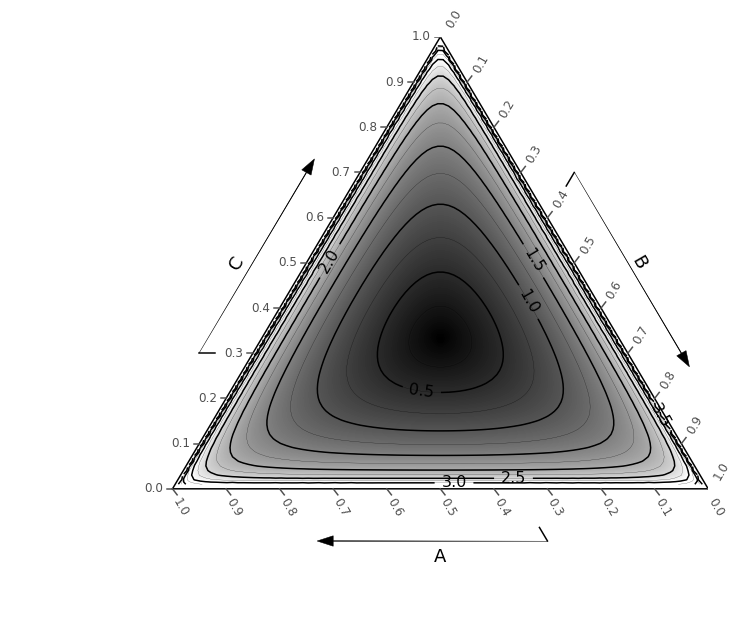

In [19]:
plot_tern(show_grid = False)
plt.contourf(coordx_i, coordy_i, ad_mesh, levels = np.linspace(0, 3, 200), cmap = 'gray')
plt.contour(coordx_i, coordy_i, ad_mesh, levels = np.linspace(0, 4, 17), colors = 'black', linewidths = 0.2)
CS = plt.contour(coordx_i, coordy_i, ad_mesh, levels = np.linspace(0, 4, 9), colors = 'black')
plt.clabel(CS, inline=1, fontsize=16, fmt='%1.1f', colors = 'black')

### What's happenning on the edges?

Better to visualize 2D compositions, but still interesting for exploration.

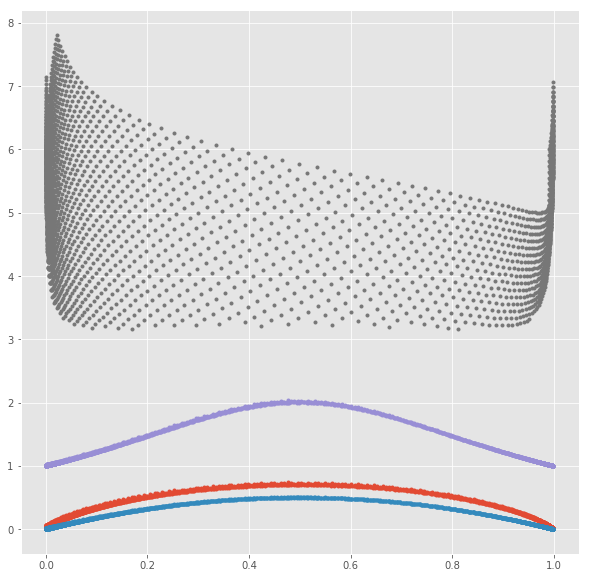

In [20]:
plt.figure(figsize(10, 10))
limit = 0.01
edge = 1
plt.plot(comp_grid[comp_grid[:,edge]<limit,0], sh_grid[comp_grid[:,edge]<limit], '.')
plt.plot(comp_grid[comp_grid[:,edge]<limit,0], si_grid[comp_grid[:,edge]<limit], '.')
plt.plot(comp_grid[comp_grid[:,edge]<limit,0], isi_grid[comp_grid[:,edge]<limit], '.')
plt.plot(comp_grid[comp_grid[:,edge]<limit,0], ad_grid[comp_grid[:,edge]<limit], '.')

Simpsons indexes share similar patterns. Both are  perfectly circular in a ternary representation. Both are also almost monotonic. However, as the inverse Simpson index becomes less sensible to high proportions for a single species (hence small proportions of others, i.e. corners of the triangle), and conversely with the Simpson index. While the Shannon-Weaver index has smooth triangular contours, it is definitely more sensible to changes near the corners (at low diversity). All three indexes return values which are not valid for any proportions. Indeed, with three species, Simpson indexes below about 0.7 - like Simpson indexes below 0.5 and Inverse Simpson indexes below 2 - cross the edge of the triangle. This may cause interpretation problems.

The Simpson indexes shared similar patterns. Both are perfectly circular in their ternary representation and almost monotonic. The inverse Simpson index shows less sensitivity to high proportions of a single species (hence small proportions of others in corners of the triangle), and conversely for the Simpson index. While the Shannon-Weaver index shows smooth triangular contours, it is definitely more sensitive to changes near corners (at low biodiversity). All three indexes returned values that are not valid for any proportion. Indeed, with three species, Simpson indexes below about 0.7 - and Simpson indexes below 0.5 and Inverse Simpson indexes below 2 - cross the edge of the triangle, where proportions fall outside of their valid space, i.e. outside the ]0, 1[ range.

# $\beta$-diversity
## Non-phylogenetic

<a list of 5 text.Text objects>

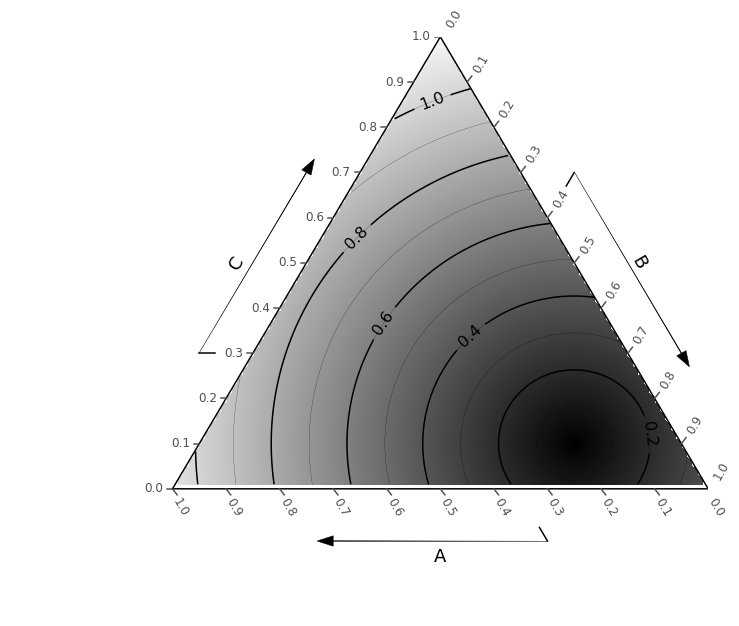

In [21]:
eucl_grid = np.apply_along_axis(func1d = distance.euclidean, v = [0.2, 0.7, 0.1], axis = 1, arr = comp_grid)

nmesh = 100
coordx_i = np.linspace(coord_grid[:, 0].min(), coord_grid[:, 0].max(), nmesh)
coordy_i = np.linspace(coord_grid[:, 1].min(), coord_grid[:, 1].max(), nmesh)
eucl_mesh = scipy.interpolate.griddata((coord_grid[:, 0], coord_grid[:, 1]), eucl_grid,
                                 (coordx_i[None,:], coordy_i[:,None]), method='cubic')

plot_tern(show_grid = False)
plt.contourf(coordx_i, coordy_i, eucl_mesh, levels = np.linspace(0, 1.2, 200), cmap = 'gray')
plt.contour(coordx_i, coordy_i, eucl_mesh, levels = np.linspace(0, 1, 11), colors = 'black', linewidths = 0.2)
CS = plt.contour(coordx_i, coordy_i, eucl_mesh, levels = np.linspace(0, 1, 6), colors = 'black')
plt.clabel(CS, inline=1, fontsize=16, fmt='%1.1f', colors = 'black')

<a list of 5 text.Text objects>

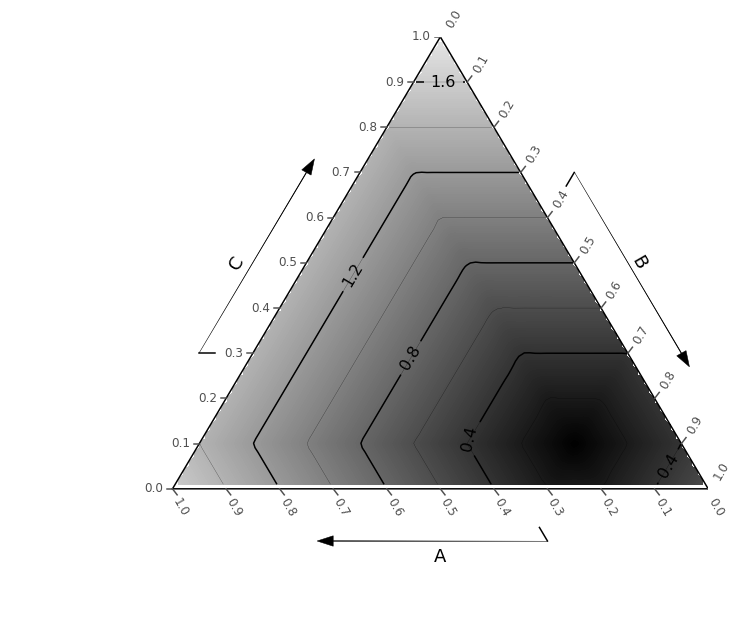

In [22]:
cb_grid = np.apply_along_axis(func1d = distance.cityblock, v = [0.2, 0.7, 0.1], axis = 1, arr = comp_grid)

nmesh = 100
coordx_i = np.linspace(coord_grid[:, 0].min(), coord_grid[:, 0].max(), nmesh)
coordy_i = np.linspace(coord_grid[:, 1].min(), coord_grid[:, 1].max(), nmesh)
cb_mesh = scipy.interpolate.griddata((coord_grid[:, 0], coord_grid[:, 1]), cb_grid,
                                 (coordx_i[None,:], coordy_i[:,None]), method='cubic')

plot_tern(show_grid = False)
plt.contourf(coordx_i, coordy_i, cb_mesh, levels = np.linspace(0, 2, 200), cmap = 'gray')
plt.contour(coordx_i, coordy_i, cb_mesh, levels = np.linspace(0, 2, 11), colors = 'black', linewidths = 0.2)
CS = plt.contour(coordx_i, coordy_i, cb_mesh, levels = np.linspace(0, 2, 6), colors = 'black')
plt.clabel(CS, inline=1, fontsize=16, fmt='%1.1f', colors = 'black')

<a list of 5 text.Text objects>

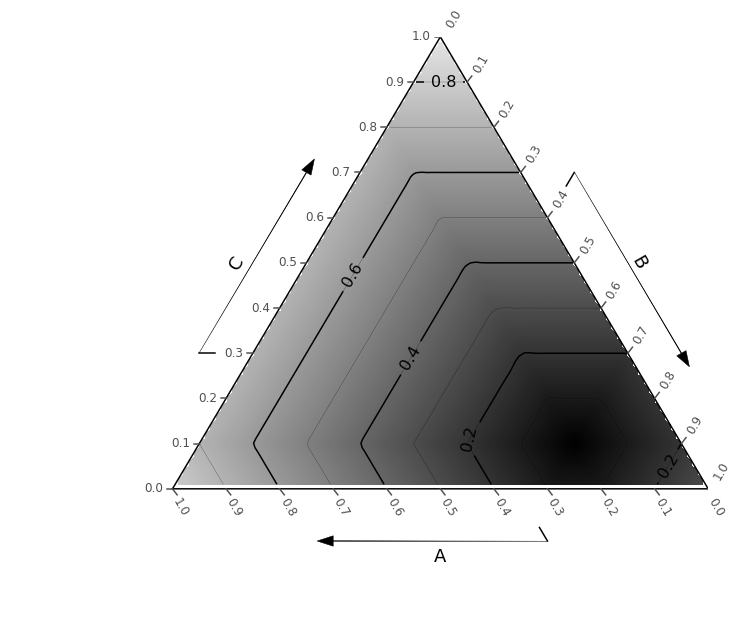

In [23]:
bc_grid = np.apply_along_axis(func1d = distance.braycurtis, v = [0.2, 0.7, 0.1], axis = 1, arr = comp_grid)

nmesh = 100
coordx_i = np.linspace(coord_grid[:, 0].min(), coord_grid[:, 0].max(), nmesh)
coordy_i = np.linspace(coord_grid[:, 1].min(), coord_grid[:, 1].max(), nmesh)
bc_mesh = scipy.interpolate.griddata((coord_grid[:, 0], coord_grid[:, 1]), bc_grid,
                                 (coordx_i[None,:], coordy_i[:,None]), method='cubic')

plot_tern(show_grid = False)
plt.contourf(coordx_i, coordy_i, bc_mesh, levels = np.linspace(0, 1, 200), cmap = 'gray') # Vega20b)
plt.contour(coordx_i, coordy_i, bc_mesh, levels = np.linspace(0, 1, 11), colors = 'black', linewidths = 0.2)
CS = plt.contour(coordx_i, coordy_i, bc_mesh, levels = np.linspace(0, 1, 6), colors = 'black')
plt.clabel(CS, inline=1, fontsize=16, fmt='%1.1f', colors = 'black')

<a list of 7 text.Text objects>

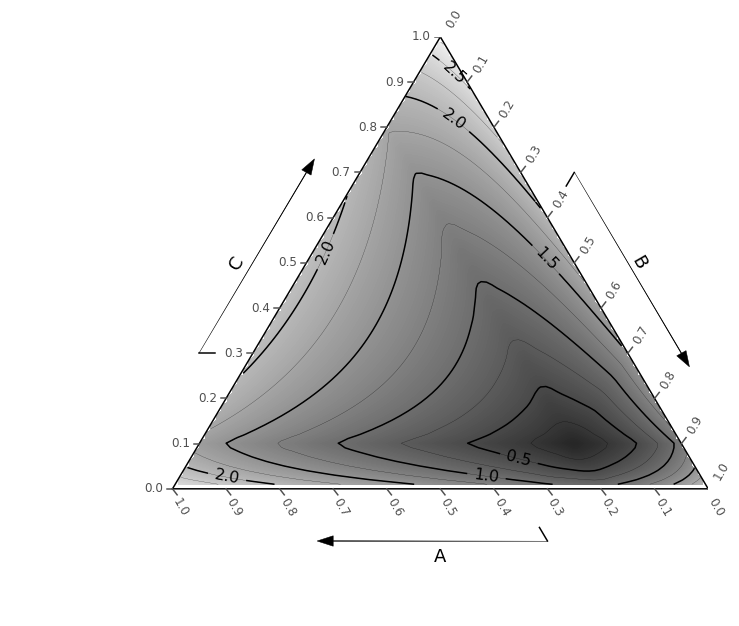

In [24]:
canb_grid = np.apply_along_axis(func1d = distance.canberra, v = [0.2, 0.7, 0.1], axis = 1, arr = comp_grid)

nmesh = 100
coordx_i = np.linspace(coord_grid[:, 0].min(), coord_grid[:, 0].max(), nmesh)
coordy_i = np.linspace(coord_grid[:, 1].min(), coord_grid[:, 1].max(), nmesh)
canb_mesh = scipy.interpolate.griddata((coord_grid[:, 0], coord_grid[:, 1]), canb_grid,
                                 (coordx_i[None,:], coordy_i[:,None]), method='cubic')

plot_tern(show_grid = False)
plt.contourf(coordx_i, coordy_i, canb_mesh, levels = np.linspace(-0.5, 3, 200), cmap = 'gray')
plt.contour(coordx_i, coordy_i, canb_mesh, levels = np.linspace(0, 4, 17), colors = 'black', linewidths = 0.2)
CS = plt.contour(coordx_i, coordy_i, canb_mesh, levels = np.linspace(0, 4, 9), colors = 'black')
plt.clabel(CS, inline=1, fontsize=16, fmt='%1.1f', colors = 'black')

<a list of 6 text.Text objects>

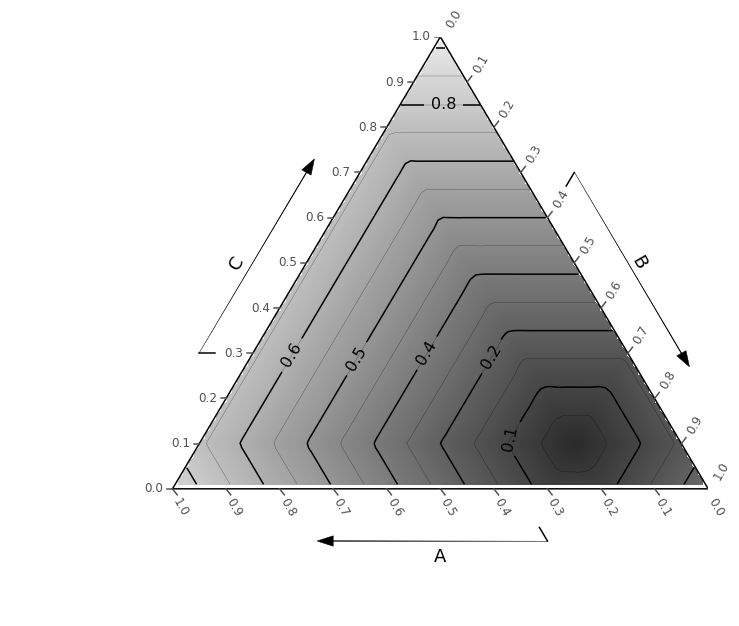

In [25]:
cheb_grid = np.apply_along_axis(func1d = distance.chebyshev, v = [0.2, 0.7, 0.1], axis = 1, arr = comp_grid)

nmesh = 100
coordx_i = np.linspace(coord_grid[:, 0].min(), coord_grid[:, 0].max(), nmesh)
coordy_i = np.linspace(coord_grid[:, 1].min(), coord_grid[:, 1].max(), nmesh)
cheb_mesh = scipy.interpolate.griddata((coord_grid[:, 0], coord_grid[:, 1]), cheb_grid,
                                 (coordx_i[None,:], coordy_i[:,None]), method='cubic')

plot_tern(show_grid = False)
plt.contourf(coordx_i, coordy_i, cheb_mesh, levels = np.linspace(-0.2, 1, 200), cmap = 'gray')
plt.contour(coordx_i, coordy_i, cheb_mesh, levels = np.linspace(0, 1, 17), colors = 'black', linewidths = 0.2)
CS = plt.contour(coordx_i, coordy_i, cheb_mesh, levels = np.linspace(0, 1, 9), colors = 'black')
plt.clabel(CS, inline=1, fontsize=16, fmt='%1.1f', colors = 'black')

<a list of 5 text.Text objects>

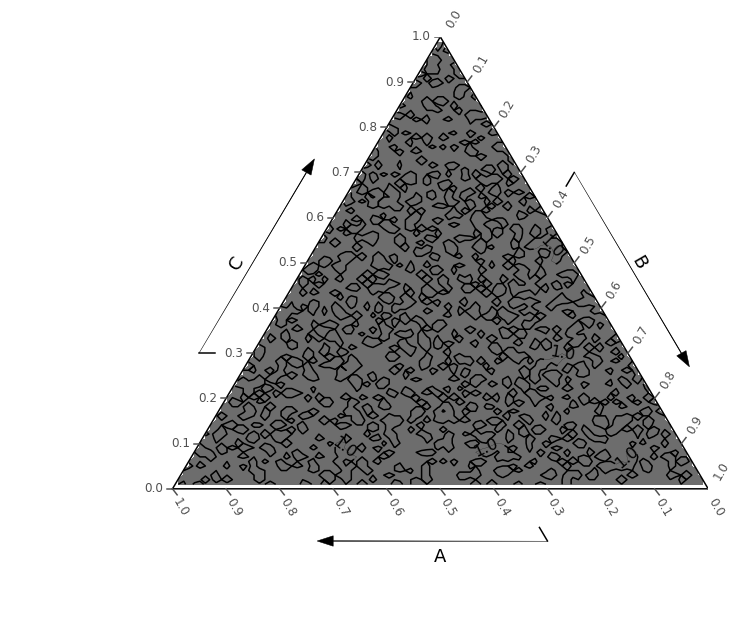

In [26]:
jacc_grid = np.apply_along_axis(func1d = distance.jaccard, v = [0.2, 0.7, 0.1], axis = 1, arr = comp_grid)

nmesh = 100
coordx_i = np.linspace(coord_grid[:, 0].min(), coord_grid[:, 0].max(), nmesh)
coordy_i = np.linspace(coord_grid[:, 1].min(), coord_grid[:, 1].max(), nmesh)
jacc_mesh = scipy.interpolate.griddata((coord_grid[:, 0], coord_grid[:, 1]), jacc_grid,
                                 (coordx_i[None,:], coordy_i[:,None]), method='cubic')

plot_tern(show_grid = False)
plt.contourf(coordx_i, coordy_i, jacc_mesh, levels = np.linspace(-0.5, 3, 200), cmap = 'gray')
plt.contour(coordx_i, coordy_i, jacc_mesh, levels = np.linspace(0, 4, 17), colors = 'black', linewidths = 0.2)
CS = plt.contour(coordx_i, coordy_i, jacc_mesh, levels = np.linspace(0, 4, 9), colors = 'black')
plt.clabel(CS, inline=1, fontsize=16, fmt='%1.1f', colors = 'black')

<a list of 8 text.Text objects>

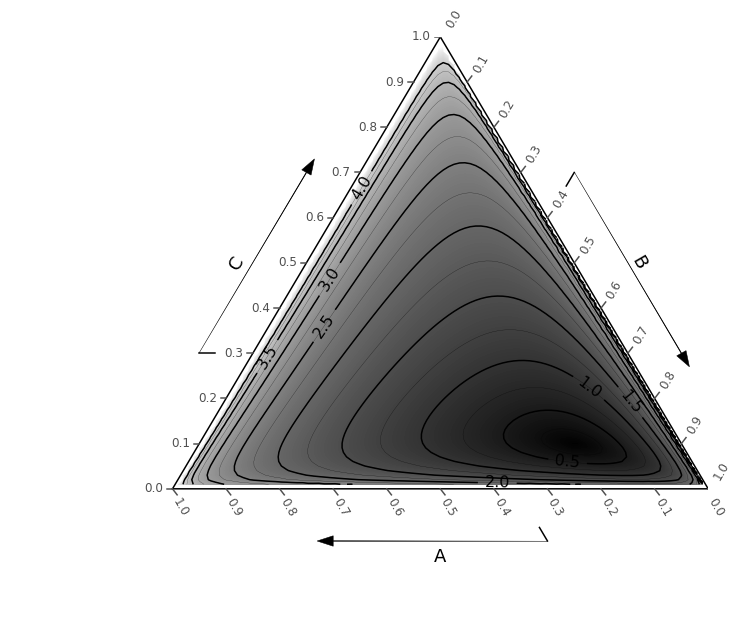

In [27]:
ad_grid = np.apply_along_axis(func1d = aitchison, v = [0.2, 0.7, 0.1], axis = 1, arr = comp_grid)

nmesh = 100
coordx_i = np.linspace(coord_grid[:, 0].min(), coord_grid[:, 0].max(), nmesh)
coordy_i = np.linspace(coord_grid[:, 1].min(), coord_grid[:, 1].max(), nmesh)
ad_mesh = scipy.interpolate.griddata((coord_grid[:, 0], coord_grid[:, 1]), ad_grid,
                                 (coordx_i[None,:], coordy_i[:,None]), method='cubic')

plot_tern(show_grid = False)
plt.contourf(coordx_i, coordy_i, ad_mesh, levels = np.linspace(0, 5, 200), cmap = 'gray')
plt.contour(coordx_i, coordy_i, ad_mesh, levels = np.linspace(0, 4, 17), colors = 'black', linewidths = 0.2)
CS = plt.contour(coordx_i, coordy_i, ad_mesh, levels = np.linspace(0, 4, 9), colors = 'black')
plt.clabel(CS, inline=1, fontsize=16, fmt='%1.1f', colors = 'black')